In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os, pathlib

sys.path.insert(0, str(pathlib.Path.cwd().parent.joinpath('src').resolve()))
from utils import *

RANDOM_STATE = 42
%matplotlib inline


In [ ]:
# Load train data (created by data_analysis.ipynb)
X_train, y_train = load_data("../data/samples/higgs_train.csv")

print("First five elements in X_train are:\n", X_train[:5])
print("First five elements in y_train are:\n", y_train[:5])
print("The shape of X_train is:", X_train.shape)
print("The shape of y_train is:", y_train.shape)
print("Label balance (mean of y_train):", float(np.mean(y_train)))


First five elements in X_train are:
          f1        f2        f3        f4        f5        f6        f7  \
0  0.719958  0.785939  0.981966  0.553060  1.383569  0.925050  1.853685   
1  0.673473  0.110004 -1.289741  1.493732  1.224188  1.020413  0.265356   
2  1.228540 -0.038039 -0.914100  0.579205  0.240356  0.813564  0.720862   
3  2.154200  0.142145 -1.209841  1.915257 -1.589158  2.047788 -1.414074   
4  1.502871 -0.042909 -0.124530  2.707755 -0.449995  0.880712 -0.276300   

         f8        f9       f10  ...       f19       f20       f21       f22  \
0 -1.074324  0.000000  0.905498  ...  0.892326  0.797247  3.101961  1.014163   
1 -0.701229  0.000000  0.920984  ... -0.327760 -1.343154  3.101961  1.564466   
2  1.177100  1.086538  1.150884  ...  1.026410  0.569178  1.550981  1.401413   
3  0.177561  0.000000  0.784379  ... -0.152867  1.314980  0.000000  0.916103   
4  1.111683  0.000000  0.771159  ... -0.712525  1.622956  0.000000  0.951986   

        f23       f24       f25

In [ ]:
# Load validation/test data (if available)
try:
    X_val, y_val = load_data("../data/samples/higgs_val.csv")
    print("Loaded validation set:", X_val.shape, y_val.shape)
except Exception as e:
    X_val, y_val = None, None
    print("Validation set not available or failed to load:", repr(e))

X_test, y_test = load_data("../data/samples/higgs_test.csv")
print("Loaded test set:", X_test.shape, y_test.shape)


Loaded validation set: (50000, 28) (50000,)
Loaded test set: (50000, 28) (50000,)


In [ ]:
# Train a Gradient Boosted Trees model
# Prefer XGBoost if installed; otherwise fall back to sklearn's HistGradientBoostingClassifier.
use_xgboost = True
try:
    import xgboost as xgb
except Exception as e:
    use_xgboost = False
    print("XGBoost not available; falling back to sklearn HistGradientBoostingClassifier.")
    print("Reason:", repr(e))

if use_xgboost:
    # XGBoost classifier (good default for tabular binary classification)
    model = xgb.XGBClassifier(
        n_estimators=5000,          
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0,
        min_child_weight=1.0,
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    if X_val is not None:
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=100,
            early_stopping_rounds=100
        )
    else:
        # If no explicit val set is present, train normally
        model.fit(X_train, y_train, verbose=False)
else:
    from sklearn.ensemble import HistGradientBoostingClassifier
    model = HistGradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=6,
        max_iter=600,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        random_state=RANDOM_STATE
    )
    model.fit(X_train, y_train)

print("Training done.")


XGBoost not available; falling back to sklearn HistGradientBoostingClassifier.
Reason: ModuleNotFoundError("No module named 'xgboost'")
Training done.


In [ ]:
# Evaluation utilities 
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay
)

def predict_proba_safe(clf, X):
    """Return P(y=1) if available."""
    if hasattr(clf, "predict_proba"):
        return clf.predict_proba(X)[:, 1]
    if hasattr(clf, "decision_function"):
        scores = clf.decision_function(X)
        return 1.0 / (1.0 + np.exp(-scores))
    # fallback: treat predictions as probabilities
    return clf.predict(X).astype(float)

def report_metrics(name, y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f'-- {name} --')
    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}')
    try:
        auc = roc_auc_score(y_true, y_prob)
        print(f'ROC AUC: {auc:.4f}')
    except Exception as e:
        print('ROC AUC failed:', repr(e))
        auc = None
    print('Confusion matrix:')
    print(confusion_matrix(y_true, y_pred))
    return {"acc":acc,"prec":prec,"rec":rec,"f1":f1,"auc":auc,"y_pred":y_pred}


In [ ]:
# Compute predictions and metrics for train/val/test
print("Preparing evaluation...")

p_train = predict_proba_safe(model, X_train)
train_metrics = report_metrics("TRAIN", y_train, p_train)

if X_val is not None:
    p_val = predict_proba_safe(model, X_val)
    val_metrics = report_metrics("VAL", y_val, p_val)
else:
    p_val = None
    val_metrics = None
    print("-- VAL -- (skipped; no validation set loaded)")

p_test = predict_proba_safe(model, X_test)
test_metrics = report_metrics("TEST", y_test, p_test)


Preparing evaluation...
-- TRAIN --
Accuracy: 0.7496, Precision: 0.7592, Recall: 0.7711, F1: 0.7651
ROC AUC: 0.8327
Confusion matrix:
[[136743  51741]
 [ 48421 163095]]
-- VAL --
Accuracy: 0.7359, Precision: 0.7467, Recall: 0.7575, F1: 0.7521
ROC AUC: 0.8157
Confusion matrix:
[[16766  6794]
 [ 6411 20029]]
-- TEST --
Accuracy: 0.7328, Precision: 0.7424, Recall: 0.7575, F1: 0.7499
ROC AUC: 0.8146
Confusion matrix:
[[16611  6950]
 [ 6412 20027]]


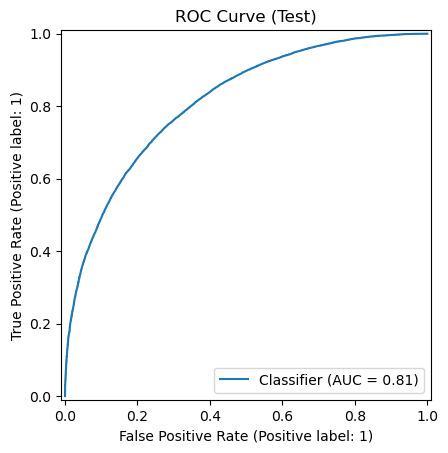

In [ ]:
# ROC curve (Test)
RocCurveDisplay.from_predictions(y_test, p_test)
plt.title("ROC Curve (Test)")
plt.show()


In [ ]:
# Feature importance (if supported)
# XGBoost: plot gain-based importances. sklearn fallback: permutation importance (optional).
if use_xgboost:
    booster = model.get_booster()
    gain = booster.get_score(importance_type="gain")  # dict: {'f0':..., 'f1':...}
    if len(gain) == 0:
        print("No importances returned (unexpected).")
    else:
        items = sorted(gain.items(), key=lambda x: x[1], reverse=True)
        top_k = 15
        top_items = items[:top_k]
        labels = [k for k,_ in top_items][::-1]
        values = [v for _,v in top_items][::-1]

        print("Top feature importances (gain):")
        for f,v in top_items:
            print(f"  {f}: {v:.4f}")

        plt.figure(figsize=(8,5))
        plt.barh(labels, values)
        plt.xlabel("gain")
        plt.title(f"Top {top_k} Feature Importances (XGBoost gain)")
        plt.show()
else:
    print("Using sklearn HistGradientBoostingClassifier; no built-in gain importance.")
    print("Optional: use sklearn.inspection.permutation_importance on a subset if needed.")


Using sklearn HistGradientBoostingClassifier; no built-in gain importance.
Optional: use sklearn.inspection.permutation_importance on a subset if needed.


In [ ]:
# (Optional) Save the trained model for reproducibility
SAVE_MODEL = False

if SAVE_MODEL:
    if use_xgboost:
        model.save_model("gbdt_xgboost.json")
        print("Saved XGBoost model to gbdt_xgboost.json")
    else:
        import joblib
        joblib.dump(model, "gbdt_sklearn.joblib")
        print("Saved sklearn model to gbdt_sklearn.joblib")


In [ ]:
!pip -q install optuna


In [ ]:
import numpy as np
import optuna

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, f1_score


In [ ]:
def best_f1_threshold(y_true, y_proba, thresholds=np.linspace(0.05, 0.95, 91)):
    best_f1 = -1.0
    best_t = 0.5
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = float(t)
    return best_f1, best_t


In [ ]:
RANDOM_STATE = 42

def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.15, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 31, 255),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 30, 400),
        "l2_regularization": trial.suggest_float("l2_regularization", 1e-5, 10.0, log=True),
        "max_bins": trial.suggest_int("max_bins", 64, 255),

        # training controls (keep stable)
        "max_iter": 3000,
        "early_stopping": True,
        "n_iter_no_change": 30,
        "validation_fraction": 0.1,     # internal early-stopping split taken ONLY from TRAIN
        "random_state": RANDOM_STATE,
    }

    model = HistGradientBoostingClassifier(**params)
    model.fit(X_train, y_train)

    val_proba = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_proba)
    val_best_f1, val_best_t = best_f1_threshold(y_val, val_proba)

    # store threshold so we can use it later (and not re-search)
    trial.set_user_attr("best_threshold", val_best_t)

    return val_auc, val_best_f1


In [ ]:
N_TRIALS = 30   # ~30 minutes at ~25s/fit

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("Completed trials:", len(study.trials))


[I 2025-12-14 21:00:09,582] A new study created in memory with name: no-name-ef9b38f1-b720-499f-a8d1-ad8ada21bd57


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-14 21:00:53,910] Trial 0 finished with values: [0.8235841328927461, 0.7709844910108749] and parameters: {'learning_rate': 0.10239671919914105, 'max_depth': 5, 'max_leaf_nodes': 177, 'min_samples_leaf': 260, 'l2_regularization': 9.938848339720735, 'max_bins': 76}.
[I 2025-12-14 21:02:47,126] Trial 1 finished with values: [0.8227905014139713, 0.7708087317385877] and parameters: {'learning_rate': 0.03639287763158581, 'max_depth': 5, 'max_leaf_nodes': 94, 'min_samples_leaf': 125, 'l2_regularization': 1.151289498428976, 'max_bins': 144}.
[I 2025-12-14 21:04:04,897] Trial 2 finished with values: [0.8237087816473985, 0.7709663105437417] and parameters: {'learning_rate': 0.042367476473774736, 'max_depth': 6, 'max_leaf_nodes': 85, 'min_samples_leaf': 94, 'l2_regularization': 3.2026367062736165, 'max_bins': 102}.
[I 2025-12-14 21:05:04,954] Trial 3 finished with values: [0.820943981504075, 0.7698036449533309] and parameters: {'learning_rate': 0.08599489960654576, 'max_depth': 4, 'max_

In [ ]:
valid_trials = [t for t in study.trials if t.values is not None]

best_f1 = max(t.values[1] for t in valid_trials)
candidates = [t for t in valid_trials if (best_f1 - t.values[1]) <= 0.003]

best_trial = max(candidates, key=lambda t: t.values[0])

print("Selected trial:")
print("  VAL AUC:", best_trial.values[0])
print("  VAL best-F1:", best_trial.values[1])
print("  Params:", best_trial.params)
print("  Best threshold:", best_trial.user_attrs["best_threshold"])


Selected trial:
  VAL AUC: 0.8260603355388373
  VAL best-F1: 0.7725626905134811
  Params: {'learning_rate': 0.05271790685528217, 'max_depth': 8, 'max_leaf_nodes': 198, 'min_samples_leaf': 323, 'l2_regularization': 1.2176158985915995e-05, 'max_bins': 155}
  Best threshold: 0.37999999999999995


In [ ]:
final_params = best_trial.params
final_model = HistGradientBoostingClassifier(
    **final_params,
    max_iter=3000,
    early_stopping=True,
    n_iter_no_change=30,
    validation_fraction=0.1,
    random_state=RANDOM_STATE
)

final_model.fit(X_train, y_train)

t_star = best_trial.user_attrs["best_threshold"]

val_proba = final_model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_proba)
val_f1, _ = best_f1_threshold(y_val, val_proba)

print("VAL AUC (recomputed):", val_auc)
print("VAL best-F1 (recomputed):", val_f1)
print("VAL chosen threshold:", t_star)


VAL AUC (recomputed): 0.8260603355388373
VAL best-F1 (recomputed): 0.7725626905134811
VAL chosen threshold: 0.37999999999999995


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score

test_proba = final_model.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= t_star).astype(int)

acc = accuracy_score(y_test, test_pred)
prec = precision_score(y_test, test_pred, zero_division=0)
rec = recall_score(y_test, test_pred, zero_division=0)
f1 = f1_score(y_test, test_pred, zero_division=0)
auc = roc_auc_score(y_test, test_proba)
cm = confusion_matrix(y_test, test_pred)

print(f"-- TEST (thr={t_star:.3f}) --")
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
print(f"ROC AUC: {auc:.4f}")
print("Confusion matrix:")
print(cm)


-- TEST (thr=0.380) --
Accuracy: 0.7317, Precision: 0.6973, Recall: 0.8705, F1: 0.7743
ROC AUC: 0.8259
Confusion matrix:
[[13569  9992]
 [ 3424 23015]]


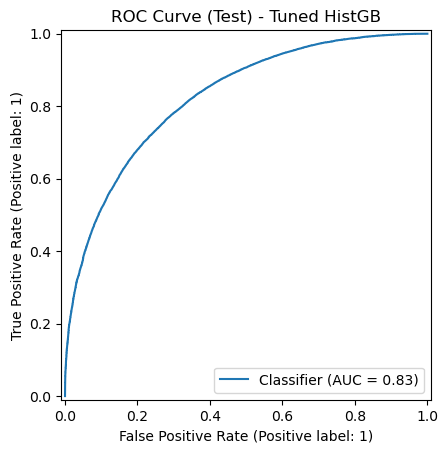

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, test_proba)
plt.title("ROC Curve (Test) - Tuned HistGB")
plt.show()
